In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


In [7]:
paper = pd.read_excel('./24_11_14_최종 학술논문 데이터(한글변환)_텍스트추가.xlsx')
# thesis = pd.read_excel('./final Text 학위논문.xlsx')

# paper = pd.concat([paper1, thesis]).reset_index(drop=True)

In [8]:
paper['Analysis_Data'] = paper['주제어'] + ',' + paper['국문 초록 (Abstract)'] + ', ' +  paper['제목'] 
paper['Analysis_Data'] = paper['Analysis_Data'].str.replace(',', ' ')
paper['Analysis_Data'] = paper['Analysis_Data'].str.replace('[^1-9a-zA-Z가-힣]',' ', regex=True).astype(str)

In [9]:
kiwi = Kiwi()
paper['doc_token'] = None
for idx, row in paper.iterrows():
    doc = row['Analysis_Data']
    nouns = []
    for sentence in kiwi.analyze(doc):
        for token in sentence[0]:
            if token.tag.startswith('NN'):
                nouns.append(token.form)
    paper.at[idx, 'doc_token'] = nouns

paper['doc_clean'] = paper['doc_token'].apply(lambda x: [word for word in x if len(word) > 1])

In [10]:
stop_words = ['연구','분석','방안','중심','관련','필요','가능','기반','제시','방법','결과','대상','의미','논문','분야','목적','중요', \
              '조사','제안','내용','인식','바탕','방식','작업','논의','수행','때문','방향','결론', '이광수','소설','문학','작품', '작가','년대', '춘원',  '이후', '당대', '본고', '시기', '문제']

def remove_stopwords(word_list, stop_words):
  filtered_words = []
  for word in word_list:
    if word not in stop_words:
      filtered_words.append(word)
  return filtered_words

In [11]:
paper['doc_clean'] = paper['doc_clean'].apply(lambda x: remove_stopwords(x, stop_words))

In [12]:
paper['doc_clean'] = paper['doc_clean'].str.join(',')

In [13]:
data_dict = {}
for key, value in paper.groupby('출판일'):
    data_dict[key] = value['doc_clean']

In [14]:
for i in data_dict.keys():
    data_dict[i] = ', '.join(data_dict[i])

In [15]:
pd.Series(data_dict).to_excel('./데이터 키워드 학술논문.xlsx', encoding='cp949')

In [16]:
data_dict

{2000: '일인칭,서술,상황, 초기,단편,이중,고찰, 노신,성장,비교,유형,비교, 치따,체험,배경,발굴, 한국,파시즘,인민주의,문화,파시즘,전반기,정치학,문화, 성장, 초기,재고, 비평,문체',
 2001: '창조,근대,문단,형성,양상, 나쓰메 소세키,도련님,무정,비교, 환영,근대,재생, 역사,단종애사, 재생,욕망,변모,양상,작중,인물,심리,변이,욕망,이론, 계몽,의식,조기,비평,논설, 육장,기관, 초기,단편,사랑,양상,윤광호, 역사,신라,정신,원효,대사, 문체,고찰, 초기,단편, 서사,논설,농촌,계발,담론,특성',
 2002: '근대성,양가,근대,여성,욕망,사회,위계,이분법,여성상,근대, 민족혼,세계관,대승기신론,진속,사상,생태,세계관,원효,대사, 죽음,미학,육체,가시,징병제,국민,문법,상상,시나리오,죽음,미학,대중,정치,반동,드라마,명성황후,내선일체, 피카레스크,교양,유럽,서사,구조,모상,무정,유럽,서사,구조,스페인,피카레스크,서사,구조,독일,교양,서사,구조,변화,과정, 노신,비교,고찰,초기,평론, 장편,계몽,의식, 재생,나체, 기독교,비평, 단종애사, 보살,서원,친일,해방,산문,시편, 국가주의,국가주의,민족주의,민주,민족,청년단,최재서,이범석,안호상,이승만,세기,한국,국가주의,기원, 무정,육체,근대,고찰, 낭만,고백,풍속,초기,단편,모티프,고찰, 논설,개인,공동체, 개척자,재고,서사, 무정,생기론, 개척자,과학,세계관,영향, 교육,텍스트,무정,개척자, 조선,후반,임화,견해',
 2003: '노신,일본,문화,서구,문화,수용,노신,일본,서구,수용,양상,비교,일본,유학, 노신,역사,역사의식,고사,노신,역사,비교,역사의식, 초기,내면,풍경,김경, 자전,의식, 윤리,재생, 우월,복합,심리,열등,복합,심리,경멸,하기,영성,지향,수성,지향,김동인,대비, 근대,명치,학원,생애,검토,출생,동경,유학,시절, 생태학,기질,기상,자연,심층,생태학,원효,원효,대사,특질,생태학,특성, 자유연애,주체,계몽,식민지,근대성,김동인,자유연애,이상,식민지,근대,현실,김동인,슬픔, 장편

In [17]:
tf_idf_result = {}

paper_data_token = pd.Series(data_dict)

for key, value in paper.groupby('출판일'):
    # Now compute the TF-IDF
    vectorizer = TfidfVectorizer()

    # Fit and transform the tokenized text into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(value['doc_clean'])

    # Convert the TF-IDF matrix into a DataFrame for better readability
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

    # Show the TF-IDF values for each term
    tf_idf_result[key] = tfidf_df

In [56]:
print(yearly_tfidf[2000])

  (0, 9)	0.5773502691896258
  (0, 10)	0.5773502691896258
  (0, 15)	0.5773502691896258
  (1, 0)	0.519708486735985
  (1, 13)	0.519708486735985
  (1, 2)	0.519708486735985
  (1, 20)	0.4355562724192789
  (2, 12)	0.38626525501710013
  (2, 7)	0.7725305100342003
  (2, 11)	0.3237204296911883
  (2, 1)	0.38626525501710013
  (3, 5)	0.5
  (3, 6)	0.5
  (3, 19)	0.5
  (3, 21)	0.5
  (4, 18)	0.2886751345948129
  (4, 17)	0.2886751345948129
  (4, 4)	0.5773502691896258
  (4, 14)	0.2886751345948129
  (4, 22)	0.5773502691896258
  (4, 23)	0.2886751345948129
  (5, 11)	1.0
  (6, 16)	0.7664298449085388
  (6, 20)	0.6423280258820045
  (7, 3)	0.7071067811865475
  (7, 8)	0.7071067811865475


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


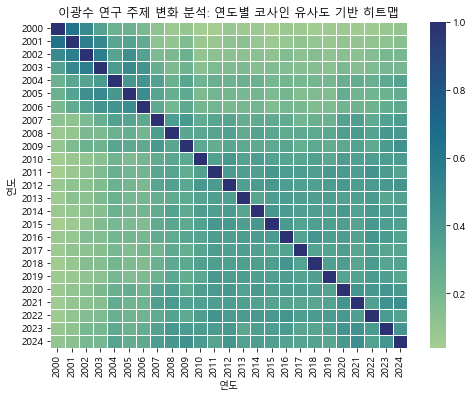

<Figure size 432x288 with 0 Axes>

In [60]:
yearly_tfidf = {}
for year, group in paper.groupby('출판일'):
    
    # Initialize TfidfVectorizer
    vectorizer = TfidfVectorizer()
    
    # Fit and transform the tokenized text into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(group['doc_clean'])
    
    # Store the TF-IDF matrix for this year
    yearly_tfidf[year] = tfidf_matrix
    
# Now, compute the cosine similarity between the yearly aggregated TF-IDF matrices

# Prepare a list of the aggregated TF-IDF vectors (mean vector for each year)
yearly_vectors = {}
for year, tfidf_matrix in yearly_tfidf.items():
    # Aggregate the TF-IDF by averaging the TF-IDF vectors of all documents in that year
    yearly_vectors[year] = tfidf_matrix.mean(axis=0).A1  # .A1 converts matrix to array


# 1. Find the maximum length of the vectors in the dictionary
max_length = max([len(vec) for vec in yearly_vectors.values()])

# 2. Pad the shorter vectors to the maximum length
for year, vector in yearly_vectors.items():
    # Calculate the number of zeros to pad
    pad_length = max_length - len(vector)
    
    # Pad with zeros at the end
    if pad_length > 0:
        padded_vector = np.pad(vector, (0, pad_length), mode='constant', constant_values=0)
    else:
        padded_vector = vector  # No padding needed if the vector is already the max length
    
    # Store the padded vector back in the dictionary
    yearly_vectors[year] = padded_vector

    
# Create a DataFrame for the cosine similarity calculations between years
years = list(yearly_vectors.keys())
cosine_sim_matrix = []

# Compute cosine similarity between each pair of years
for year1 in years:
    sim_row = []
    for year2 in years:
        cosine_sim = cosine_similarity([yearly_vectors[year1]], [yearly_vectors[year2]])
        sim_row.append(cosine_sim[0][0])  # Extract the scalar value from the similarity matrix
    cosine_sim_matrix.append(sim_row)

# Convert the cosine similarity matrix into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=years, columns=years)

# Display the cosine similarity matrix
# print("\nCosine Similarity Between Years:")
# print(cosine_sim_df)

# Plot the heatmap
plt.figure(figsize=(8, 6))
# sns.heatmap(cosine_sim_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', linewidths=0.5)
sns.heatmap(cosine_sim_df, cmap='crest', linewidths=0.5)
plt.title("이광수 연구 주제 변화 분석: 연도별 코사인 유사도 기반 히트맵")
plt.xlabel("연도")
plt.ylabel("연도")
plt.show()
plt.savefig('코사인 유사도 히트맵.png')

In [20]:
cosine_sim_df
mean_except_one = cosine_sim_df[cosine_sim_df != 1].stack().mean()
mean_except_one

0.30552505670289143

In [21]:
for i in cosine_sim_df.index:
    if i in cosine_sim_df.columns:  # Check if the index also exists as a column
        cosine_sim_df.at[i, i] = np.nan

In [22]:
cosine_sim_df.to_excel('cos_sim.xlsx')

In [23]:
np.nanmean(cosine_sim_df.values)

0.2777460589710073

In [24]:
np.nanmean(cosine_sim_df.loc[:2003, :2003].values)

0.5152144518193598

In [25]:
np.nanmean(cosine_sim_df.loc[2003:2006, 2003:2006].values)

0.4361627115698514

In [26]:
np.nanmean(cosine_sim_df.loc[2007:2010, 2007:2010].values)

0.3277141330303153

In [27]:
np.nanmean(cosine_sim_df.loc[2011:, 2011:].values)

0.3693888657889766

In [28]:
import pandas as pd
import numpy as np

# Example DataFrame - assume df is your cosine similarity DataFrame with years as both rows and columns
# df = pd.DataFrame(...)

# Dictionary to store results
range_averages = {}

# Loop through all possible consecutive year ranges
for start_year in cosine_sim_df.index:
    for end_year in cosine_sim_df.index:
        if end_year >= start_year:  # Ensure we're only considering consecutive ranges
            # Select the submatrix corresponding to the range
            sub_df = cosine_sim_df.loc[start_year:end_year, start_year:end_year]
            # Calculate the mean of the selected range, ignoring NaNs
            range_mean = np.nanmean(sub_df.values)
            # Store the result in the dictionary
            range_averages[f"{start_year}~{end_year}"] = range_mean

# Convert the dictionary to a DataFrame for easier viewing (optional)
range_averages_df = pd.DataFrame(list(range_averages.items()), columns=["Year Range", "Average Cosine Similarity"])

# Display the results
range_averages_df.to_excel('consecutive_data.xlsx')


c:\ProgramData\Anaconda3\envs\dacontech\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [29]:
import pandas as pd
import numpy as np

# Example DataFrame - assume df is your cosine similarity DataFrame with years as both rows and columns
# df = pd.DataFrame(...)

# Dictionary to store results
range_averages = {}

# Step 1: Calculate the average for each consecutive year range
for start_year in cosine_sim_df.index:
    for end_year in cosine_sim_df.index:
        if end_year >= start_year:  # Ensure we're only considering consecutive ranges
            # Select the submatrix corresponding to the range
            sub_df = cosine_sim_df.loc[start_year:end_year, start_year:end_year]
            # Calculate the mean of the selected range, ignoring NaNs
            range_mean = np.nanmean(sub_df.values)
            # Store the result in the dictionary
            range_averages[f"{start_year}~{end_year}"] = {
                "start": start_year,
                "end": end_year,
                "average": range_mean
            }

# Step 2: Convert to DataFrame for easier processing
range_averages_df = pd.DataFrame(range_averages).T  # Transpose to get the structure right
range_averages_df = range_averages_df.sort_values(by="average", ascending=False)

# Step 3: Select the top 3 non-overlapping ranges
selected_ranges = []
for _, row in range_averages_df.iterrows():
    # Check for overlap with previously selected ranges
    if all((row["start"] > selected["end"]) or (row["end"] < selected["start"]) for selected in selected_ranges):
        selected_ranges.append(row)
    # Stop if we already have 3 ranges
    if len(selected_ranges) == 3:
        break

# Display the selected ranges
print("Top 3 Non-Overlapping Year Ranges with Highest Average Cosine Similarity:")
for i, selected in enumerate(selected_ranges, 1):
    print(f"{i}: {selected['start']}~{selected['end']} with average similarity {selected['average']}")


c:\ProgramData\Anaconda3\envs\dacontech\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


Top 3 Non-Overlapping Year Ranges with Highest Average Cosine Similarity:
1: 2000.0~2001.0 with average similarity 0.6374864740112078
2: 2002.0~2003.0 with average similarity 0.567843161008133
3: 2005.0~2006.0 with average similarity 0.47672639337405204


In [30]:
pd.DataFrame(range_averages).T.to_csv('./yearly_cos_sim_val.csv')

In [31]:
exclude_n_from_year = paper[paper['성별'] != 'n']

exclude_n_from_age = paper[paper['생년'] != 'n']

In [32]:
exclude_n_from_age['생년'] = exclude_n_from_age['생년'].astype(str).str[:-1] + '0'

c:\ProgramData\Anaconda3\envs\dacontech\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [33]:
year = []
male = []
female = []

year_age = []
age_30 = []
age_40 = []
age_50 = []
age_60 = []
age_70 = []
age_80 = []
age_90 = []


age_dict={}

for key, value in exclude_n_from_year.groupby('출판일'):
    year.append(key)
    gender = value['성별'].value_counts()
    male.append(gender['남'])
    female.append(gender['여'])

for key, value in exclude_n_from_age.groupby('출판일'):
    year_age.append(key)
    age = value['생년'].value_counts()
    try:
        age_30.append(age['1930'])
    except:
        age_30.append(0)

    try:
        age_40.append(age['1940'])
    except:
        age_40.append(0)

    try:
        age_50.append(age['1950'])
    except:
        age_50.append(0)

    try:
        age_60.append(age['1960'])
    except:
        age_60.append(0)

    try:
        age_70.append(age['1970'])
    except:
        age_70.append(0)

    try:
        age_80.append(age['1980'])
    except:
        age_80.append(0)

    try:
        age_90.append(age['1990'])
    except:
        age_90.append(0)

In [34]:
df = pd.DataFrame({'연도' : year, '남성':male, '여성':female})

df['남성 비율'] = round(df['남성'] / (df['남성'] + df['여성']) * 100, 2)
df['여성 비율'] = round(df['여성'] / (df['남성'] + df['여성']) * 100, 2)

In [35]:
df_age = pd.DataFrame({'연도' : year
                       , '1930':age_30
                       , '1940':age_40
                       , '1950':age_50
                       , '1960':age_60
                       , '1970':age_70
                       , '1980':age_80
                       , '1990':age_90
                       })



df_age['total'] = df_age.iloc[:, 1:].sum(axis=1)

df_age['1930년생 비율'] = round(df_age['1930'] / df_age['total'] * 100 , 2)
df_age['1940년생 비율'] = round(df_age['1940'] / df_age['total'] * 100 , 2)
df_age['1950년생 비율'] = round(df_age['1950'] / df_age['total'] * 100 , 2)
df_age['1960년생 비율'] = round(df_age['1960'] / df_age['total'] * 100 , 2)
df_age['1970년생 비율'] = round(df_age['1970'] / df_age['total'] * 100 , 2)
df_age['1980년생 비율'] = round(df_age['1980'] / df_age['total'] * 100 , 2)
df_age['1990년생 비율'] = round(df_age['1990'] / df_age['total'] * 100 , 2)


# (2-1) 저자 연도별 성별비중 추이


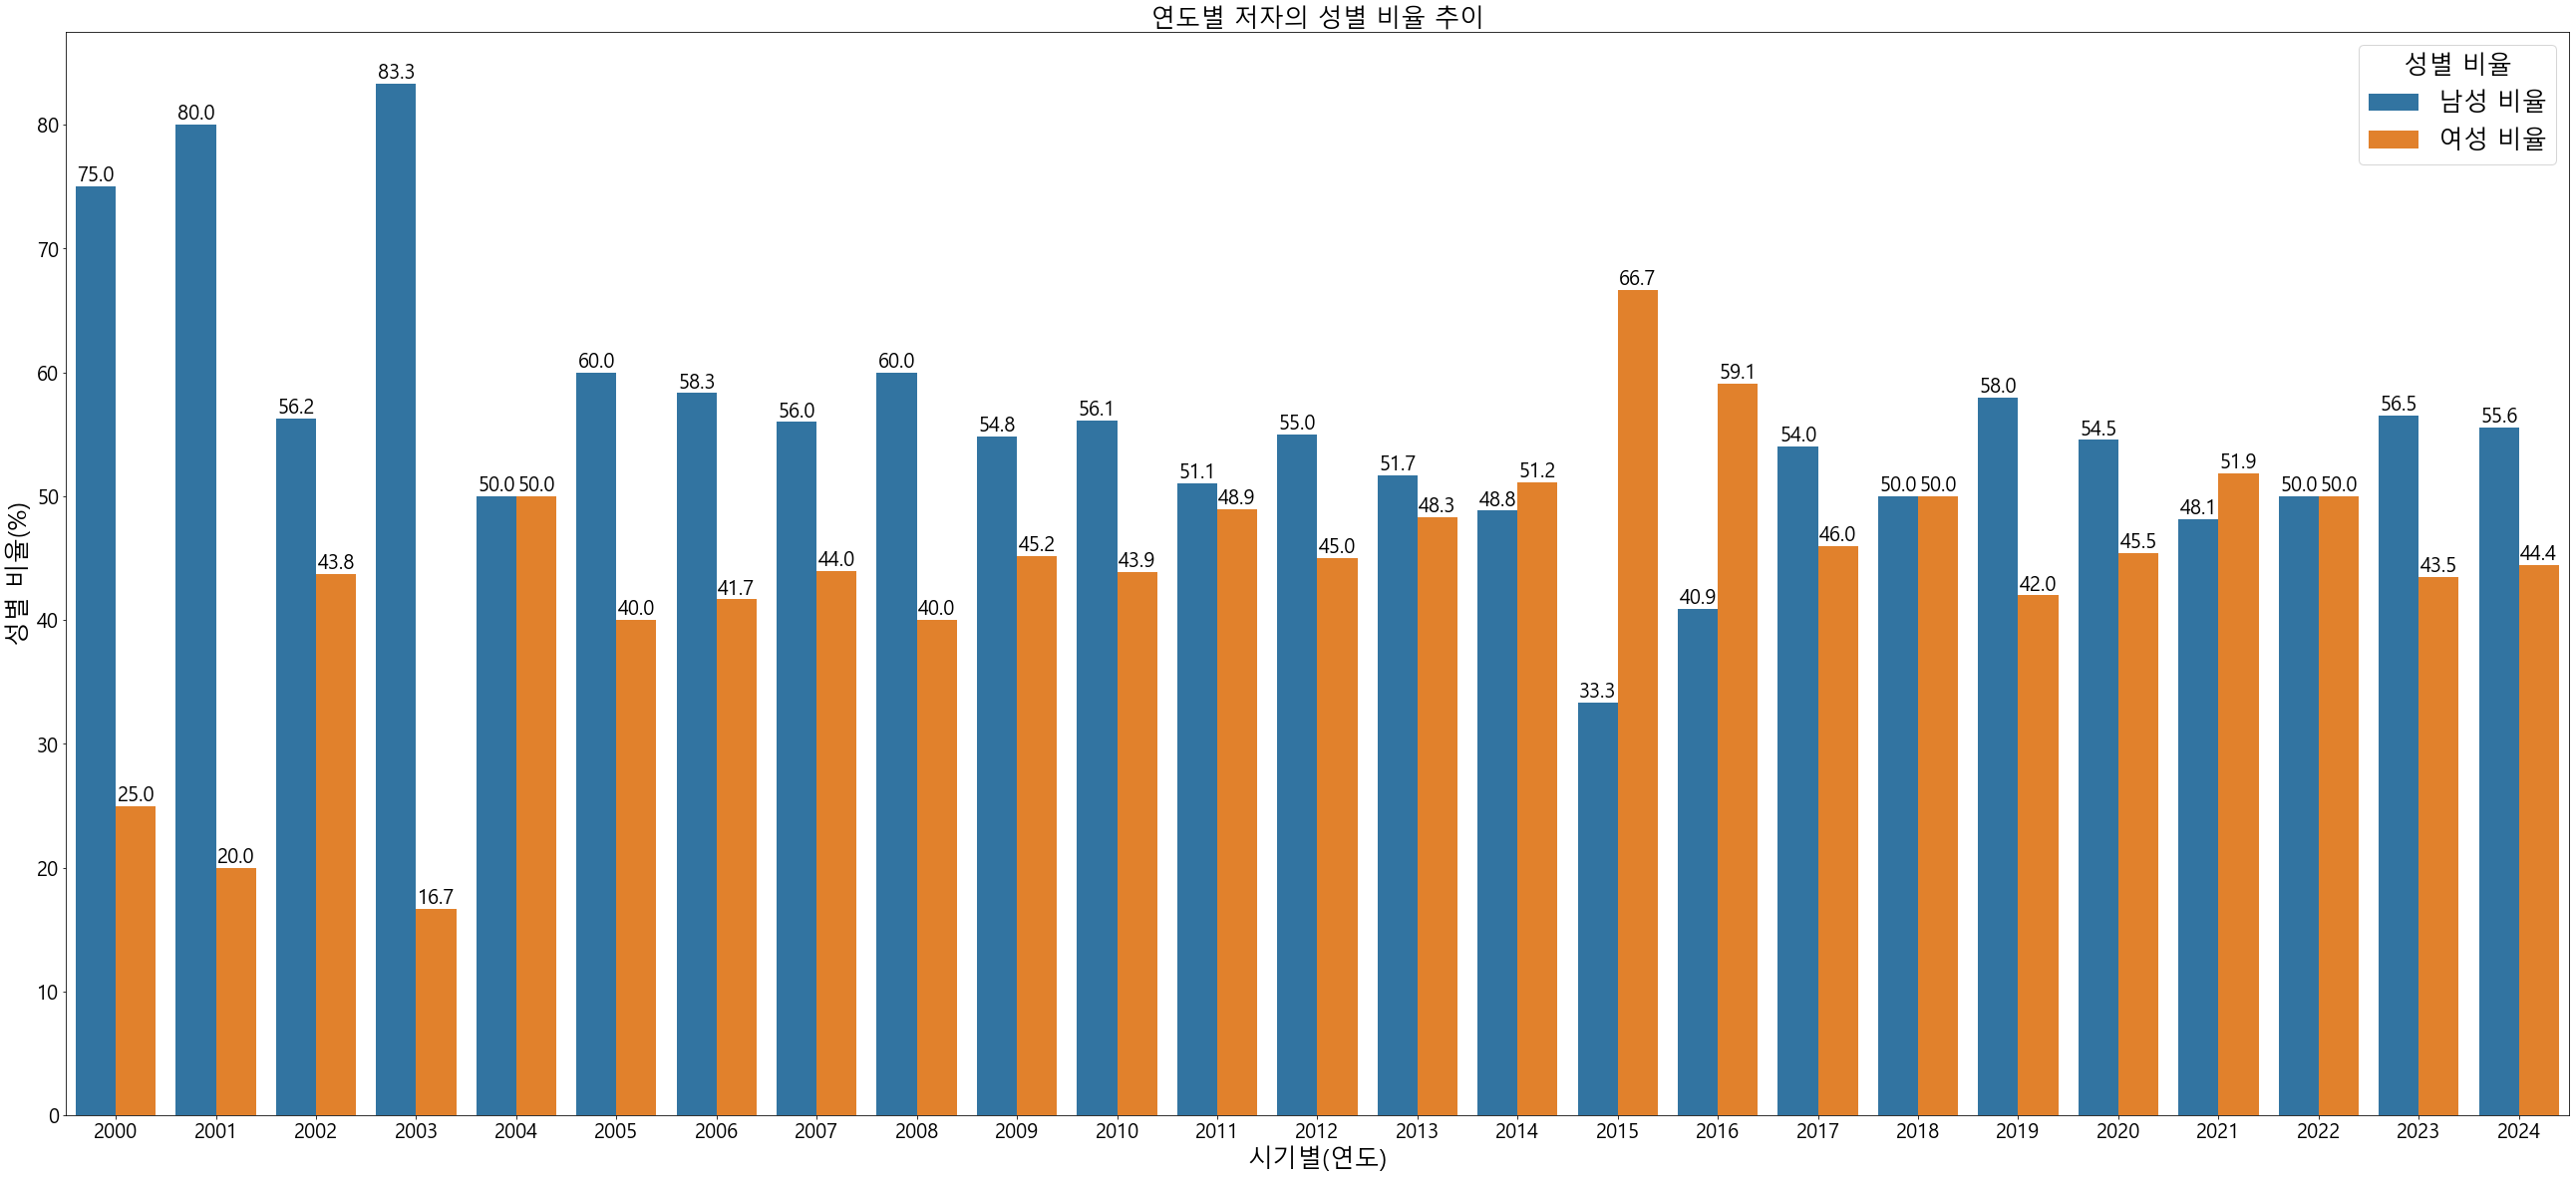

In [36]:
fig, ax = plt.subplots(figsize=(45, 20))

df_melted = df.melt(id_vars=['연도'], value_vars = ['남성 비율','여성 비율'], var_name='성별', value_name='인원 비율')

sns.barplot(x = '연도', y='인원 비율', hue='성별', data=df_melted)

plt.title('연도별 저자의 성별 비율 추이', fontsize=25)  # Set Korean title and font size

ax.legend(title='성별 비율', title_fontsize=25, fontsize=25)
plt.xticks(fontsize=20)  # X-axis tick labels font size
plt.yticks(fontsize=20)  # Y-axis tick labels font size
plt.xlabel('시기별(연도)', fontsize=25)
plt.ylabel('성별 비율(%)', fontsize=25)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=20)

4 시기별 빈출 텍스트 분석 : 어떤 텍스트가 인용되었는가?

#    (2-2) 저자 연도별 세대변화 (30, 40, 50, 60, 70, 80, 90년대생)


['1930년생 비율', '1940년생 비율', '1950년생 비율', '1960년생 비율', '1970년생 비율', '1980년생 비율', '1990년생 비율']
Categories (7, object): ['1930년생 비율', '1940년생 비율', '1950년생 비율', '1960년생 비율', '1970년생 비율', '1980년생 비율', '1990년생 비율']


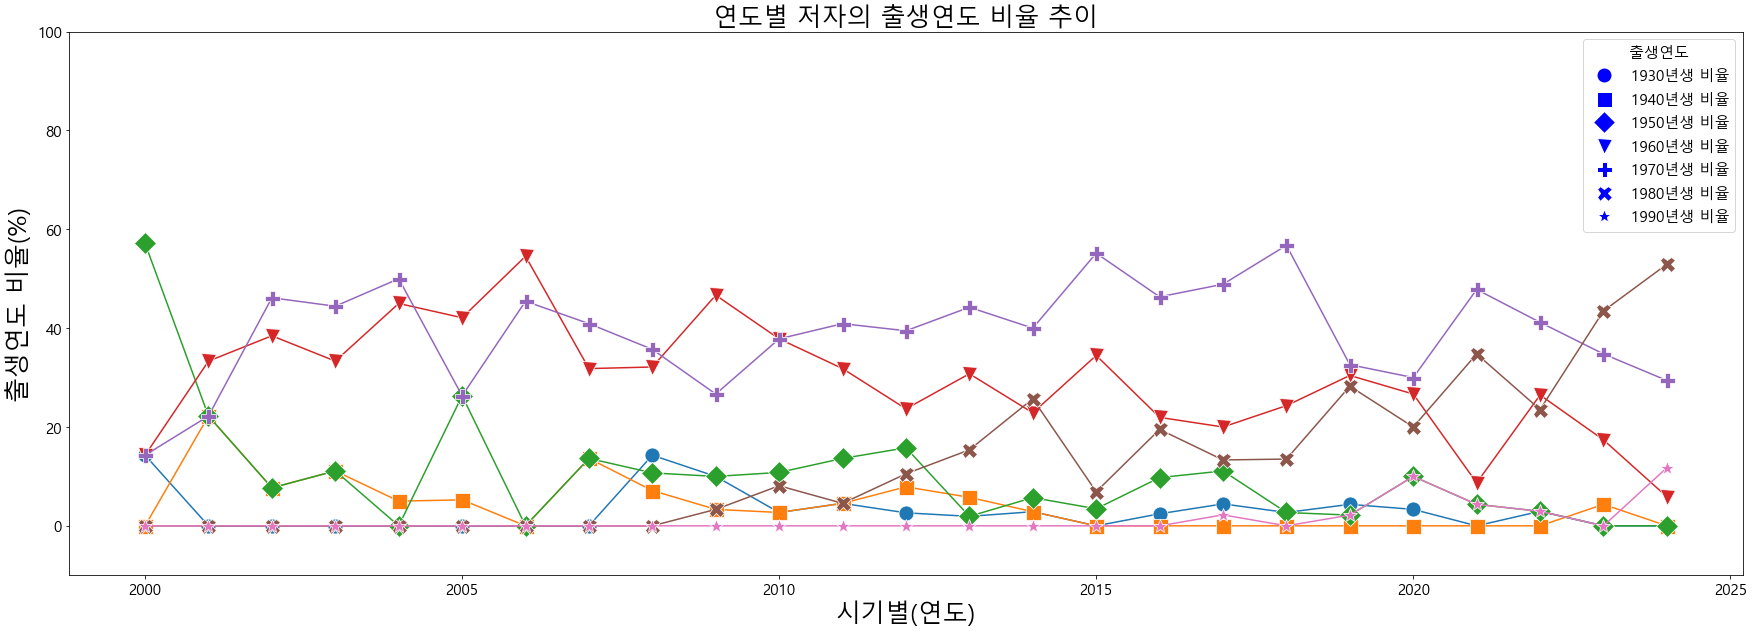

In [37]:
from matplotlib.lines import Line2D  # To create custom legend handles

df_melted = df_age.melt(id_vars=['연도']
                        , value_vars = ['1930년생 비율'
                                        ,'1940년생 비율'
                                        ,'1950년생 비율'
                                        ,'1960년생 비율'
                                        ,'1970년생 비율'
                                        ,'1980년생 비율'
                                        ,'1990년생 비율']
                        , var_name='출생년'
                        , value_name='인원 비율')


# Remove duplicates if necessary (based on year and birth year)
df_melted = df_melted.drop_duplicates(subset=['연도', '출생년'])

# Ensure '출생년' is categorical (for correct hue handling)
df_melted['출생년'] = pd.Categorical(df_melted['출생년'])

# Check the unique values of '출생년' to confirm there are exactly 7 categories
print(df_melted['출생년'].unique())

# Create the plot
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_ylim(-10, 100)

# Plot the lineplot
sns.lineplot(x='연도', y='인원 비율', hue='출생년', data=df_melted)

# Define markers for each line
markers = ['o', 's', 'D', 'v', 'P', 'X', '*']

# Set marker and marker size for each line
for i, line in enumerate(ax.lines):
    if i < len(markers):  # Only set markers for the first 7 lines
        line.set_marker(markers[i])  # Set the marker style
        line.set_markersize(15)      # Set the marker size

legend_handles = []

for i, marker in enumerate(markers):
    legend_handles.append(Line2D([0], [0], marker=marker, color='w', markerfacecolor='b', markersize=15, label=f'{df_melted["출생년"].cat.categories[i]}'))

# Customize plot
plt.title('연도별 저자의 출생연도 비율 추이', fontsize=25)
ax.legend(handles=legend_handles, title='출생연도', title_fontsize=15, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('시기별(연도)', fontsize=25)
plt.ylabel('출생연도 비율(%)', fontsize=25)
plt.show()

# 3-1 전체 시기의 상위 빈도 단어 Count 표

### 3450년대생 남/녀, 60년대생 남/녀, 70년대생 남/녀 8090년대생 남/녀

In [38]:
from collections import Counter

# Step 1: Combine all the rows into one large string
all_text = ','.join(paper['doc_clean'])

# Step 2: Split the string by commas into words
words = all_text.split(',')

# Step 3: Count the frequency of each word using Counter
word_counts = Counter(words)

# Step 4: Convert the Counter result into a pandas DataFrame for easy visualization
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the word counts
word_counts_df.to_excel('./전체 단어 순위.xlsx')


# 3-2 연구자 세대X성별로 나눠 본 빈출단어

In [39]:
male_3450 = exclude_n_from_age[(exclude_n_from_age['성별'] == '남' ) & (exclude_n_from_age['생년']<= '1950')]
female_3450 = exclude_n_from_age[(exclude_n_from_age['성별'] == '여' ) & (exclude_n_from_age['생년']<= '1950')]

male_60 = exclude_n_from_age[(exclude_n_from_age['성별'] == '남' ) & (exclude_n_from_age['생년']== '1960')]
female_60 = exclude_n_from_age[(exclude_n_from_age['성별'] == '여' ) & (exclude_n_from_age['생년']== '1960')]

male_70 = exclude_n_from_age[(exclude_n_from_age['성별'] == '남' ) & (exclude_n_from_age['생년']== '1970')]
female_70 = exclude_n_from_age[(exclude_n_from_age['성별'] == '여' ) & (exclude_n_from_age['생년']== '1970')]

male_890 = exclude_n_from_age[(exclude_n_from_age['성별'] == '남' ) & (exclude_n_from_age['생년']>= '1980')]
female_890 = exclude_n_from_age[(exclude_n_from_age['성별'] == '여' ) & (exclude_n_from_age['생년']>= '1980')]

In [40]:
from collections import Counter

def counts(paper):
    # Step 1: Combine all the rows into one large string
    all_text = ','.join(paper['doc_clean'])

    # Step 2: Split the string by commas into words
    words = all_text.split(',')

    # Step 3: Count the frequency of each word using Counter
    word_counts = Counter(words)

    # Step 4: Convert the Counter result into a pandas DataFrame for easy visualization
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

    # Display the word counts
    # word_counts_df.to_excel('./전체 단어 순위.xlsx')
    return word_counts_df

m_345 = counts(male_3450)
f_345 = counts(female_3450)

m_6 = counts(male_60)
f_6 = counts(female_60)

m_7 = counts(male_70)
f_7 = counts(female_70)

m_89 = counts(male_890)
f_89 = counts(female_890)

In [41]:
m_345.to_excel('./345남 단어 빈도.xlsx')
f_345.to_excel('./345여 단어 빈도.xlsx')

m_6.to_excel('./6남 단어 빈도.xlsx')
f_6.to_excel('./6여 단어 빈도.xlsx')

m_7.to_excel('./7남 단어 빈도.xlsx')
f_7.to_excel('./7여 단어 빈도.xlsx')

m_89.to_excel('./89남 단어 빈도.xlsx')
f_89.to_excel('./89여 단어 빈도.xlsx')

In [42]:
x = [
m_345.reset_index(drop=True),
f_345.reset_index(drop=True),

m_6.reset_index(drop=True),
f_6.reset_index(drop=True),

m_7.reset_index(drop=True),
f_7.reset_index(drop=True),

m_89.reset_index(drop=True),
f_89.reset_index(drop=True)]

pd.concat(x, axis=1, sort=True,ignore_index=True).to_excel('성별, 시기별 단어 빈도수.xlsx')

In [43]:
f_89

,Word,Frequency
15,근대,91
264,번역,77
2,조선,58
504,사랑,55
31,서사,48
...,...,...
1095,직시,1
229,시조,1
1097,호모섹슈,1
1098,얼리,1


# 3-3 시기별 빈출단어 표나 워드클라우드 만들고, 없으면 생략 

In [44]:
dataset = {}

for key, value in paper.groupby('출판일'):
    dataset[key] = value

In [45]:
count_data = {}

for key in dataset:
    count_data[key] = counts(dataset[key])

In [46]:
# xx = pd.DataFrame()
for i in count_data:
    count_data[i].to_excel(str(i) + '년 단어 빈도.xlsx')

In [47]:
xx = pd.DataFrame()
for i in count_data:
    xx = pd.concat([xx, count_data[i].reset_index(drop=True),], axis=1)

In [48]:
xx.to_excel('연도별 단어 빈도수.xlsx')

# 4 시기별 빈출 텍스트 분석 : 어떤 텍스트가 인용되었는가

In [49]:
xx

,Word,Frequency,Word,Frequency,Word,Frequency,Word,Frequency,Word,Frequency,...,Word,Frequency,Word,Frequency,Word,Frequency,Word,Frequency,Word,Frequency
0,초기,2.0,양상,3.0,서사,5.0,무정,6.0,근대,27.0,...,근대,36.0,근대,56.0,근대,41.0,세계,36.0,한국,29.0
1,문화,2.0,역사,2.0,구조,4.0,근대,5.0,무정,17.0,...,운동,30.0,민족,37.0,세계,38.0,근대,29.0,시조,29.0
2,성장,2.0,욕망,2.0,무정,4.0,일본,5.0,괴테,14.0,...,언문,26.0,조선,20.0,조선,37.0,서사,27.0,글쓰기,24.0
3,비교,2.0,근대,2.0,고찰,3.0,계몽,5.0,문명,13.0,...,일치,24.0,서사,19.0,주체,32.0,민족,26.0,민족,24.0
4,파시즘,2.0,초기,2.0,근대,3.0,식민지,5.0,교육,12.0,...,조선,24.0,계몽,18.0,번역,26.0,조선,23.0,조선,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
